Mounted at /content/drive


,Year,RM,Oats,Barley
0,1938,1,1.0,1.0
1,1939,1,16.0,16.0
2,1940,1,23.0,19.0
3,1941,1,32.0,28.0
4,1942,1,35.0,28.0
...,...,...,...,...
25602,2019,622,106.0,73.9
25603,2020,622,94.5,74.3
25604,2021,622,25.8,23.3
25605,2022,622,93.0,76.9


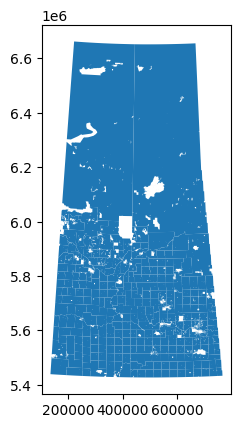

In [1]:
# Mounting google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install mapclassify
!pip install mapclassify
!pip install tensorflow


# Importin Libraries
import pandas as pd # Data manipulation
import numpy as np # Matrix calculation
import geopandas as gpd # GIS of Pandas
import seaborn as sb # Parof of matplotlib for Data Viz
import matplotlib.pyplot as plt # data viz
from mapclassify import classify



# Defining Directories
directory_main = "/content/drive/MyDrive/PalleteSkills/"

#GIS
directory_gis= directory_main + 'SK_RM_Shapefiles/RuralMunicipality.shp'

# Yield
directory_rm_yields = directory_main + 'rm-yields-data.csv'

# Reading GIS
gdf_rm=gpd.read_file(directory_gis)

gdf_rm.plot()


# Reading Yields
df_rm_yields=pd.read_csv(directory_rm_yields)
# Reading GIS
gdf_rm=gpd.read_file(directory_gis)


df_rm_oats_n_barley_crops = df_rm_yields[['Year', 'RM','Oats','Barley']]
df_rm_oats_n_barley_crops

Epoch 1/20
2049/2049 - 19s - loss: 565.8634 - val_loss: 289.8501 - 19s/epoch - 9ms/step
Epoch 2/20
2049/2049 - 13s - loss: 265.6233 - val_loss: 250.8294 - 13s/epoch - 6ms/step
Epoch 3/20
2049/2049 - 13s - loss: 248.0899 - val_loss: 241.0056 - 13s/epoch - 7ms/step
Epoch 4/20
2049/2049 - 16s - loss: 243.1173 - val_loss: 240.7750 - 16s/epoch - 8ms/step
Epoch 5/20
2049/2049 - 14s - loss: 239.5231 - val_loss: 237.7695 - 14s/epoch - 7ms/step
Epoch 6/20
2049/2049 - 14s - loss: 237.4321 - val_loss: 233.2511 - 14s/epoch - 7ms/step
Epoch 7/20
2049/2049 - 13s - loss: 234.9401 - val_loss: 229.2358 - 13s/epoch - 6ms/step
Epoch 8/20
2049/2049 - 13s - loss: 232.2084 - val_loss: 230.0010 - 13s/epoch - 6ms/step
Epoch 9/20
2049/2049 - 13s - loss: 230.7409 - val_loss: 229.1981 - 13s/epoch - 7ms/step
Epoch 10/20
2049/2049 - 14s - loss: 228.8171 - val_loss: 221.4687 - 14s/epoch - 7ms/step
Epoch 11/20
2049/2049 - 13s - loss: 226.3083 - val_loss: 218.1950 - 13s/epoch - 7ms/step
Epoch 12/20
2049/2049 - 14s - 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 867ms/step
Predicted Oats and Barley production: [[10.666034 11.00923 ]]


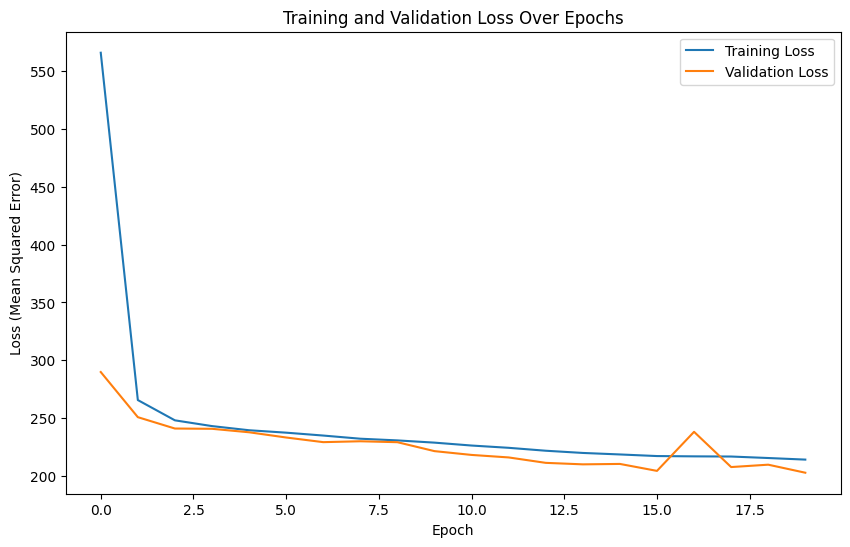

801/801 [==============================] - 2s 3ms/step


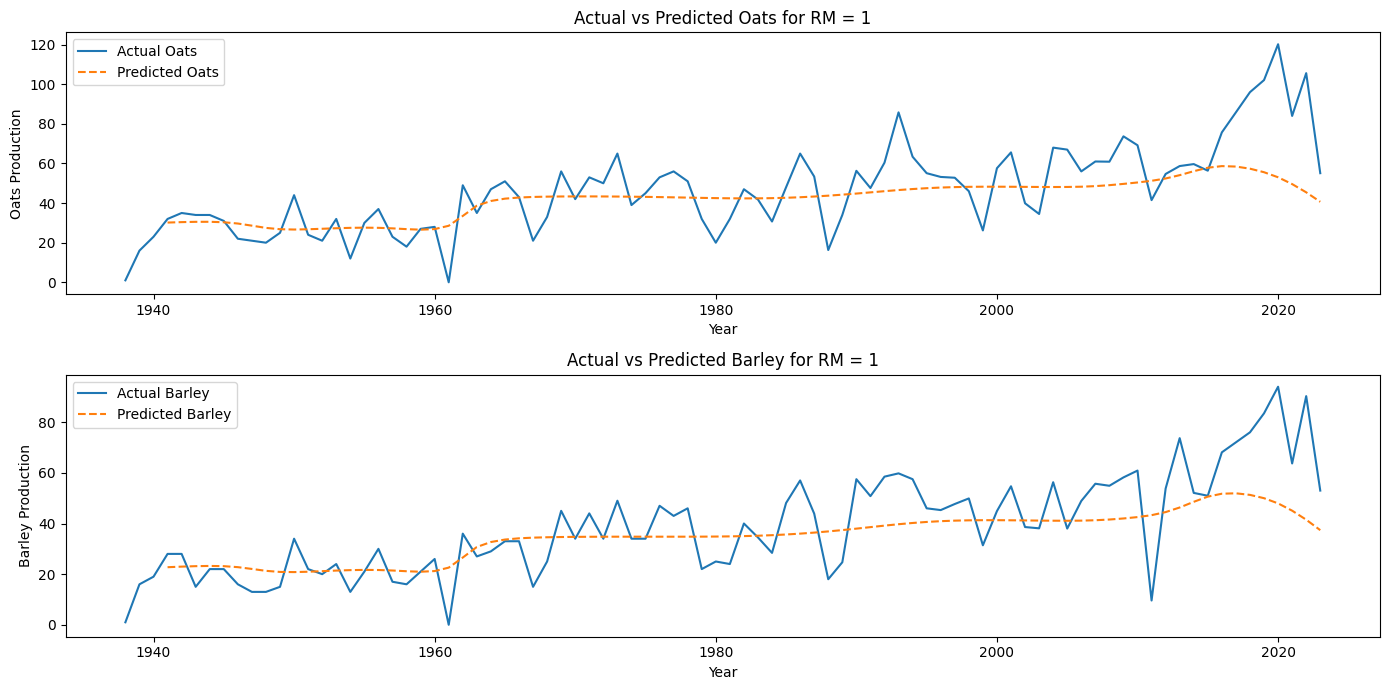

In [6]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


df = df_rm_oats_n_barley_crops.copy()

# Interpolate missing values using .loc
df.loc[:, 'Oats'] = df['Oats'].interpolate()
df.loc[:, 'Barley'] = df['Barley'].interpolate()

# Ensure no missing values remain
assert df.isna().sum().sum() == 0, "There are still missing values in the dataset."

# Scale numerical variables
scaler = MinMaxScaler()
df[['Year', 'RM']] = scaler.fit_transform(df[['Year', 'RM']])

# Prepare the inputs and outputs
X = df[['Year', 'RM']]
Y = df[['Oats', 'Barley']]

# Reshape the data to be suitable for LSTM
def create_lstm_dataset(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        Ys.append(Y.iloc[i + time_steps].values)
    return np.array(Xs), np.array(Ys)

time_steps = 3
X_lstm, Y_lstm = create_lstm_dataset(X, Y, time_steps)

# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_lstm, Y_lstm, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[1])))
model.add(LSTM(50))
model.add(Dense(2))  # Output layer for Oats and Barley

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=20, batch_size=10, validation_data=(X_val, Y_val), verbose=2)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {test_loss}")


# Example prediction for a specific year and RM
# Note: The Year and RM should be scaled using the same scaler used during training
example_year_rm = scaler.transform([[2080, 5], [2080, 5], [2080, 5]])  # Provide 3 timesteps of data
example_input = np.array([example_year_rm])
prediction = model.predict(example_input)
print("Predicted Oats and Barley production:", prediction)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()



# Make predictions
Y_pred = model.predict(X_lstm)

# Inverse transform the scaled features to get the original RM values
df[['Year', 'RM']] = scaler.inverse_transform(df[['Year', 'RM']])

# Filter actual and predicted values for RM = 1
df['Oats_pred'] = np.nan
df['Barley_pred'] = np.nan

# Align the predicted values with the original dataframe
df.iloc[time_steps:, -2:] = Y_pred

# Filter for RM = 1
rm = 1
df_rm1 = df[df['RM'] == rm]

# Plot the actual vs prediction for Oats and Barley
plt.figure(figsize=(14, 7))

# Plot for Oats
plt.subplot(2, 1, 1)
plt.plot(df_rm1['Year'], df_rm1['Oats'], label='Actual Oats')
plt.plot(df_rm1['Year'], df_rm1['Oats_pred'], label='Predicted Oats', linestyle='--')
plt.title(f'Actual vs Predicted Oats for RM = {rm}')
plt.xlabel('Year')
plt.ylabel('Oats Production')
plt.legend()

# Plot for Barley
plt.subplot(2, 1, 2)
plt.plot(df_rm1['Year'], df_rm1['Barley'], label='Actual Barley')
plt.plot(df_rm1['Year'], df_rm1['Barley_pred'], label='Predicted Barley', linestyle='--')
plt.title(f'Actual vs Predicted Barley for RM = {rm}')
plt.xlabel('Year')
plt.ylabel('Barley Production')
plt.legend()

plt.tight_layout()
plt.show()

# **Future Predicton**


1/1 [==============================] - 0s 22ms/step


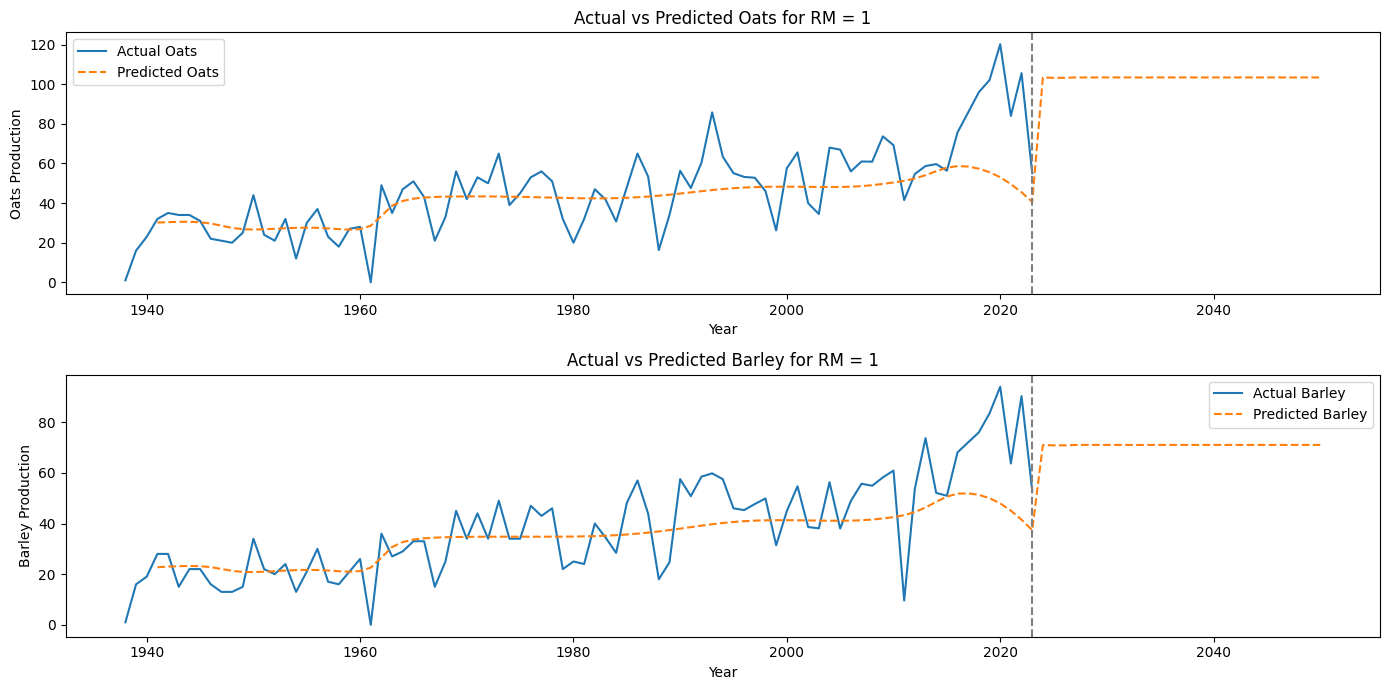

In [7]:
# Make predictions for future years until 2050
future_years = list(range(2024, 2051))
#last_rm = df['RM'].values[-1]
last_rm = rm
last_values = df[['Year', 'RM']].values[-time_steps:]

# Prepare the input for the model
X_future = last_values.tolist()

future_predictions = []
for year in future_years:
    next_input = np.array(X_future[-time_steps:]).reshape((1, time_steps, 2))
    pred = model.predict(next_input)
    future_predictions.append(pred[0])
    next_input = [year, last_rm]  # Use the current year and the same RM value
    X_future.append(next_input)
    X_future = X_future[1:]  # Slide the window

# Convert predictions to DataFrame
future_predictions = np.array(future_predictions)
df_future = pd.DataFrame(future_predictions, columns=['Oats_pred', 'Barley_pred'])
df_future['Year'] = future_years
df_future['RM'] = last_rm

# Merge the previous predicted data with the future predictions
df_merged_oats = pd.concat([df_rm1[['Year', 'Oats_pred']], df_future[['Year', 'Oats_pred']]], ignore_index=True)
df_merged_barley = pd.concat([df_rm1[['Year', 'Barley_pred']], df_future[['Year', 'Barley_pred']]], ignore_index=True)

# Plot the actual vs prediction for Oats and Barley
plt.figure(figsize=(14, 7))

# Plot for Oats
plt.subplot(2, 1, 1)
plt.plot(df_rm1['Year'], df_rm1['Oats'], label='Actual Oats')
plt.plot(df_merged_oats['Year'], df_merged_oats['Oats_pred'], label='Predicted Oats', linestyle='--')
plt.axvline(x=2023, color='gray', linestyle='--')  # Mark the division between actual and predicted
plt.title(f'Actual vs Predicted Oats for RM = {last_rm}')
plt.xlabel('Year')
plt.ylabel('Oats Production')
plt.legend()

# Plot for Barley
plt.subplot(2, 1, 2)
plt.plot(df_rm1['Year'], df_rm1['Barley'], label='Actual Barley')
plt.plot(df_merged_barley['Year'], df_merged_barley['Barley_pred'], label='Predicted Barley', linestyle='--')
plt.axvline(x=2023, color='gray', linestyle='--')  # Mark the division between actual and predicted
plt.title(f'Actual vs Predicted Barley for RM = {last_rm}')
plt.xlabel('Year')
plt.ylabel('Barley Production')
plt.legend()

plt.tight_layout()
plt.show()
